In [1]:
from data_preprocessing import *
from clustering import *
from strategy import *

In [2]:
DEMO = True
## Data file for the demo
filename = "data/demo.tar" if DEMO else "data/period_data.tar"

First, we explore the provided data; how many minutes of data are we missing for the period ? We chose to remove stocks that had more than 25% of data missing for the period. 

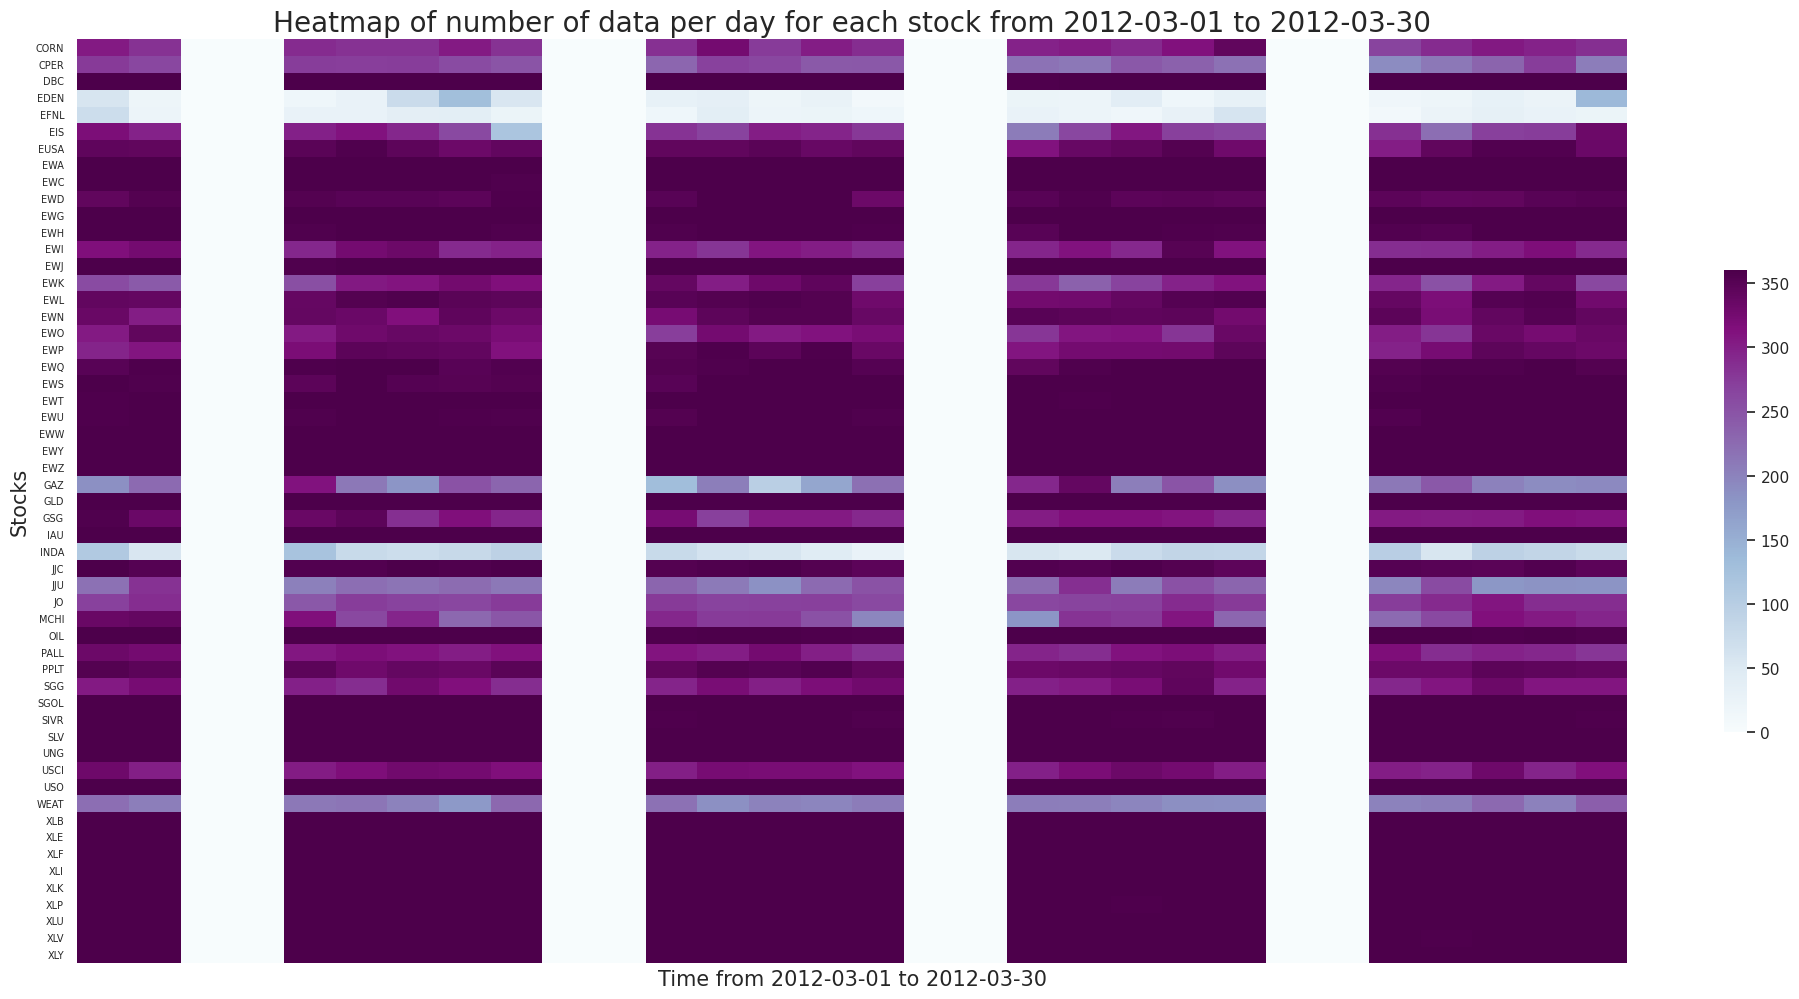

We remove the 8 stocks with more than 25% missing minutes: CPER, EDEN, EFNL, GAZ, INDA, JJU, JO, WEAT
We are now working with : 47 stocks.
The missing minutes values were now filled.


In [3]:
period_data = preprocessing(filename)
# we can also use period_data = load_data("data/cleaned_data.tar") to load the data instead

In [4]:
ret = compute_returns_eod(period_data)

Then, based on our data, we compute the Louvain clustering algorithm to obtain our daily market states. 

Daily data shape: (17, 16920)
There are 7 clusters
The length of each clusters are Cluster
0    1
1    1
2    1
3    6
4    1
5    1
6    6
dtype: int64


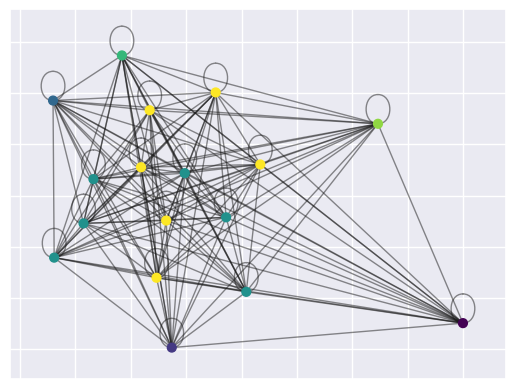

In [5]:
clusters, min_window = classify_test_data(period_data)
clusters.index = pd.to_datetime(clusters.index)

In [6]:
# set day as index
clusters.set_index('Day', inplace=True)
clusters.index = pd.to_datetime(clusters.index)
clusters


,Cluster
Day,
2012-03-01,0
2012-03-02,3
2012-03-05,4
2012-03-06,3
2012-03-07,3
2012-03-08,3
2012-03-09,6
2012-03-12,6
2012-03-13,6


In [7]:
 # drop lines in trades in for which we don't have clusters
ret = ret[ret.index.isin(clusters.index)]

In [8]:
from strategy import * 


def rolling_backtest(df_states, df_trades, min_window_size=30, quantile=0.25):
    """
    Performs a rolling window backtest of the investment strategy.

    Parameters:
    - strategy_func: Function to apply the investment strategy
    - df_states: DataFrame with market states for each day
    - df_trades: DataFrame with log returns for each stock per day
    - window_size: Number of past days to consider in the rolling window
    - strat: The investment strategy to use (e.g., 'tan', 'w_ret', etc.)
    - quantile: Percentage of top and bottom stocks to long and short (default 10%)

    Returns:
    - results_df: DataFrame containing portfolio returns for each day in the test period
    """
    results =  pd.DataFrame(index=df_states.index[min_window_size:])
    strats = ['tan', 'w_ret', 'top_bottom', 'momentum', 'risk_parity']

    for strat in strats:
        for i in tqdm(range(min_window_size, len(df_states))):
            
            # Select rolling window for states and trades
            rolling_states = df_states.iloc[: i + 1]
            rolling_return = df_trades.iloc[: i + 1]

            # Call the investment strategy function
            weights = investment_strategy(strat, rolling_states, rolling_return, quantile)

            # Compute portfolio return using today's actual returns (excluding the last day)
            portfolio_return = compute_portfolio_return(weights, rolling_return.iloc[-1])

            # Add a column to the results DataFrame with name strat + '_return'
            results.loc[df_states.index[i], 'c_' + strat + '_return'] = portfolio_return

            # Redo without clusters
            weights = investment_strategy(strat, rolling_states, rolling_return, quantile, use_cluster=False)

            # Compute portfolio return using today's actual returns (excluding the last day)
            portfolio_return = compute_portfolio_return(weights, rolling_return.iloc[-1])

            results.loc[df_states.index[i], strat + '_return'] = portfolio_return


        # Convert results to a DataFrame
        results_df = pd.DataFrame(results)
        

    return results_df

In [12]:
results = rolling_backtest(clusters, ret, min_window)

  0%|          | 0/17 [00:00<?, ?it/s]/home/mpittelo/miniconda3/envs/fbd/lib/python3.12/site-packages/pandas/core/frame.py:11211: RuntimeWarning: Degrees of freedom <= 0 for slice
  base_cov = np.cov(mat.T, ddof=ddof)
/home/mpittelo/miniconda3/envs/fbd/lib/python3.12/site-packages/numpy/lib/function_base.py:2748: RuntimeWarning: divide by zero encountered in divide
  c *= np.true_divide(1, fact)
/home/mpittelo/miniconda3/envs/fbd/lib/python3.12/site-packages/numpy/lib/function_base.py:2748: RuntimeWarning: invalid value encountered in multiply
  c *= np.true_divide(1, fact)
/home/mpittelo/miniconda3/envs/fbd/lib/python3.12/site-packages/pandas/core/frame.py:11211: RuntimeWarning: Degrees of freedom <= 0 for slice
  base_cov = np.cov(mat.T, ddof=ddof)
/home/mpittelo/miniconda3/envs/fbd/lib/python3.12/site-packages/numpy/lib/function_base.py:2748: RuntimeWarning: divide by zero encountered in divide
  c *= np.true_divide(1, fact)
/home/mpittelo/miniconda3/envs/fbd/lib/python3.12/site-pac

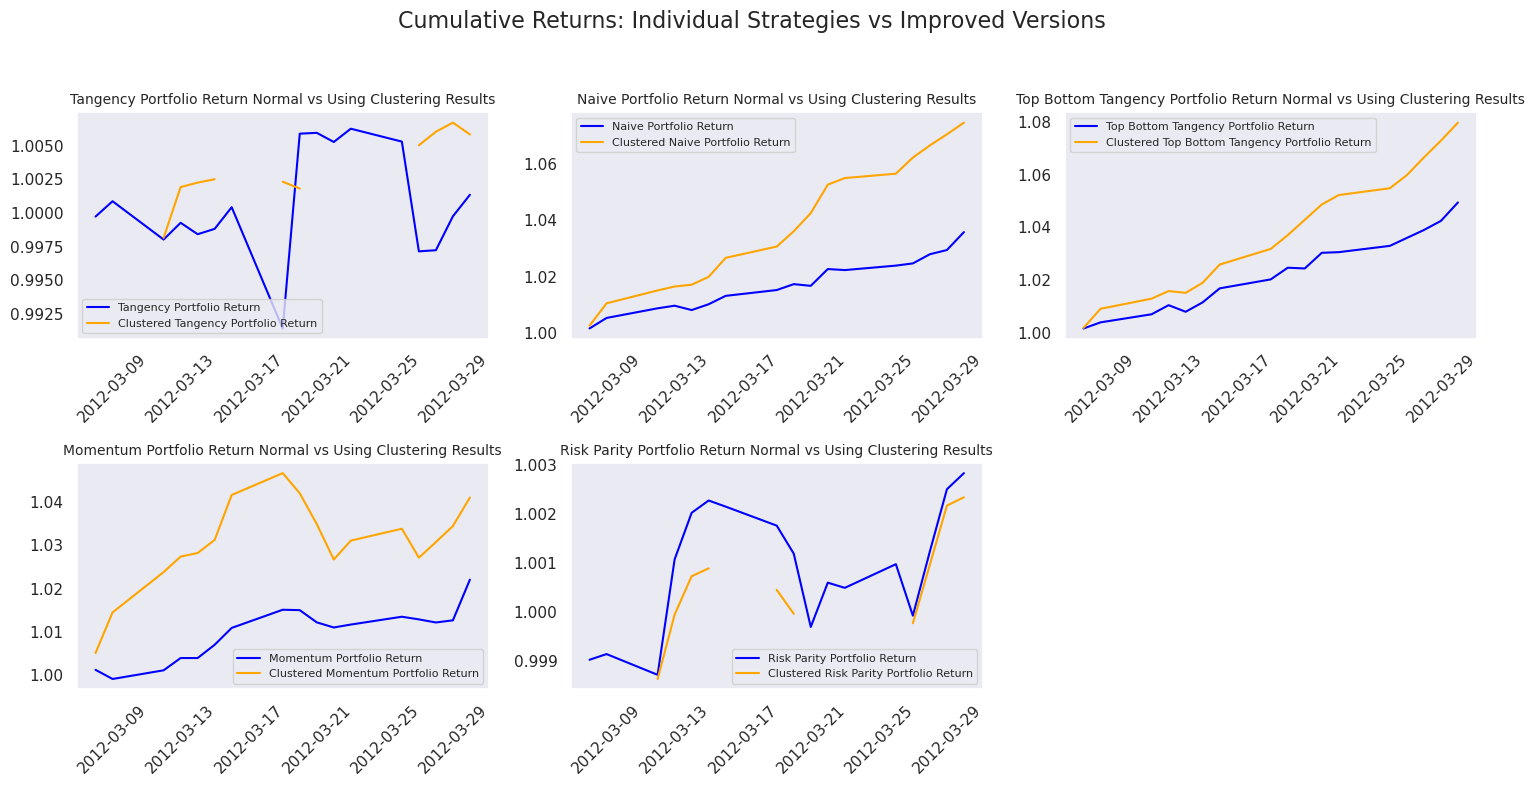

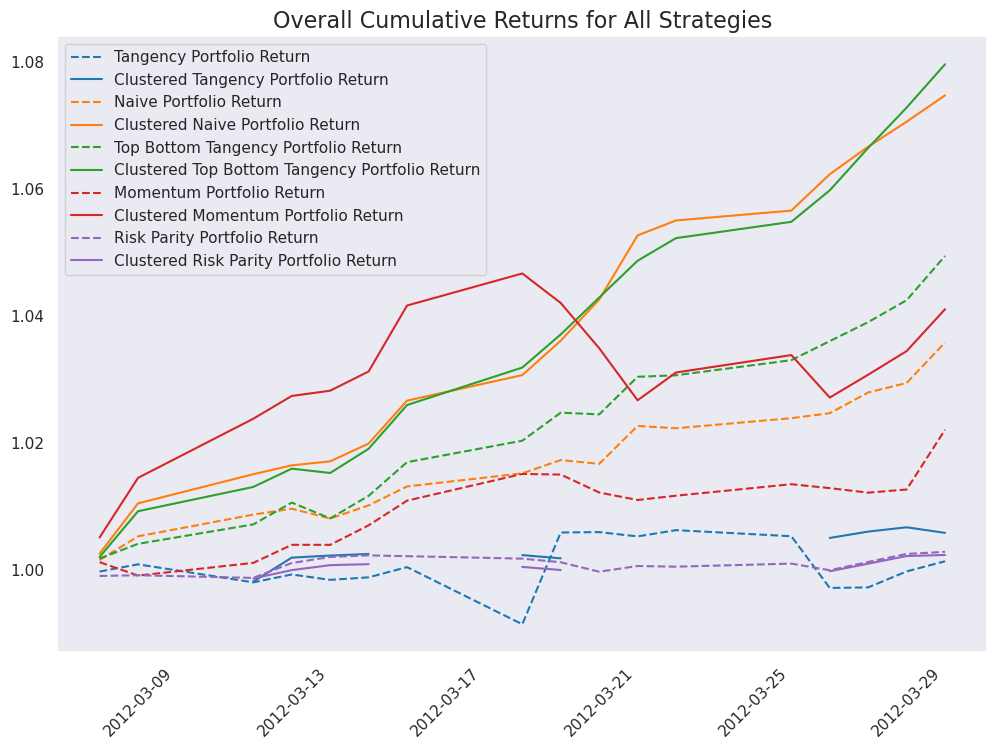

In [10]:
# Compute cumulative returns
cumulative_results = (1 + results).cumprod()

strategies = ['tan_return', 'w_ret_return', 'top_bottom_return', 'momentum_return', 'risk_parity_return']
strategies_name = ['Tangency Portfolio Return', 'Naive Portfolio Return', 'Top Bottom Tangency Portfolio Return', 'Momentum Portfolio Return', 'Risk Parity Portfolio Return']

# 1. Grid of cumulative returns: Individual vs Improved
fig, axes = plt.subplots(nrows=2, ncols=len(strategies) // 2 + len(strategies) % 2, figsize=(15, 8))
fig.suptitle('Cumulative Returns: Individual Strategies vs Improved Versions', fontsize=16)

for i, strategy in enumerate(strategies):
    row, col = divmod(i, len(axes[0]))
    ax = axes[row][col]
    ax.plot(cumulative_results.index, cumulative_results[strategy], label=f"{strategies_name[i]}", color='blue')
    ax.plot(cumulative_results.index, cumulative_results[f"c_{strategy}"], label=f"Clustered {strategies_name[i]}", color='orange')
    ax.set_title(f"{strategies_name[i]} Normal vs Using Clustering Results", fontsize=10)
    ax.legend(fontsize=8)
    ax.grid()
    ax.tick_params(axis='x', labelrotation=45)

if len(strategies) % 2 != 0:
    axes[-1, -1].axis("off")

plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.savefig("stratvs.jpg")
plt.show()

# 2. Additional Graph: Overall Cumulative Returns for All Strategies
plt.figure(figsize=(12, 8))
colors = sns.color_palette("tab10", n_colors=len(strategies)) 
for i, strategy in enumerate(strategies):
    plt.plot(
        cumulative_results.index,
        cumulative_results[strategy],
        label=f"{strategies_name[i]}",
        linestyle='--',
        color=colors[i]
    )  # Non-improved strategies with dashed lines
    plt.plot(
        cumulative_results.index,
        cumulative_results[f"c_{strategy}"],
        label=f"Clustered {strategies_name[i]}",
        linestyle='-',
        color=colors[i]
    )  # Improved strategies with solid lines
plt.title("Overall Cumulative Returns for All Strategies", fontsize=16)
plt.legend()
plt.grid()
plt.xticks(rotation=45) 
plt.savefig("allstrats.jpg")

plt.show()
